In [6]:
# --- Step 1: Imports & Setup ---

import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Paths
DATA_DIR = "../sample-data/processed"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")
TEST_DIR  = os.path.join(DATA_DIR, "test")

# Sanity check
for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    print(d, "→", os.listdir(d))


Using device: cpu
../sample-data/processed/train → ['fake', 'real']
../sample-data/processed/val → ['fake', 'real']
../sample-data/processed/test → ['fake', 'real']


In [7]:
# --- Step 2: Define Transforms ---

IMG_SIZE = 224  # same as what we used for face crops

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [8]:
# --- Step 3: Load Datasets ---

train_dataset = ImageFolder(root=TRAIN_DIR, transform=train_transforms)
val_dataset   = ImageFolder(root=VAL_DIR, transform=val_test_transforms)
test_dataset  = ImageFolder(root=TEST_DIR, transform=val_test_transforms)

print("Classes:", train_dataset.classes)
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


Classes: ['fake', 'real']
Train: 937, Val: 480, Test: 473


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


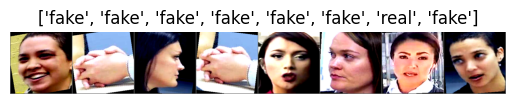

In [9]:
# --- Step 4: Visualize Random Samples ---

def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize for visualization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Make a grid
out = torchvision.utils.make_grid(images[:8])
imshow(out, title=[train_dataset.classes[l] for l in labels[:8]])


In [10]:
# --- Step 5: Quick Sanity Check ---

from collections import Counter

train_counts = Counter([train_dataset.classes[label] for _, label in train_dataset.samples])
val_counts   = Counter([val_dataset.classes[label] for _, label in val_dataset.samples])
test_counts  = Counter([test_dataset.classes[label] for _, label in test_dataset.samples])

print("Train class distribution:", train_counts)
print("Val class distribution:", val_counts)
print("Test class distribution:", test_counts)


Train class distribution: Counter({'fake': 701, 'real': 236})
Val class distribution: Counter({'fake': 362, 'real': 118})
Test class distribution: Counter({'fake': 359, 'real': 114})


In [11]:
# --- Step 6: Model Definition ---

import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load pretrained EfficientNet
model = models.efficientnet_b0(weights='IMAGENET1K_V1')

# Freeze base layers (optional for fine-tuning)
for param in model.features.parameters():
    param.requires_grad = False

# Modify classifier head for binary classification
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 1)  # single output for BCEWithLogitsLoss

model = model.to(device)
print(model)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/sudeep/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:01<00:00, 18.6MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
# --- Step 7: Define Loss, Optimizer, Scheduler ---

criterion = nn.BCEWithLogitsLoss()  # because our output is a single logit (real/fake)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2)

print("Loss:", criterion)
print("Optimizer:", optimizer)


Loss: BCEWithLogitsLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


In [14]:
# --- Step 8: Training and Validation Loop ---

from sklearn.metrics import accuracy_score
import time

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    preds, labels_all = [], []

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy().round())
        labels_all.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(labels_all, preds)
    return epoch_loss, epoch_acc


def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    preds, labels_all = [], []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating", leave=False):
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds.extend(torch.sigmoid(outputs).detach().cpu().numpy().round())
            labels_all.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(labels_all, preds)
    return epoch_loss, epoch_acc


# --- Training Loop ---
NUM_EPOCHS = 10
best_val_loss = float('inf')

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc:  {train_acc:.4f} | Val Acc:  {val_acc:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Saved new best model!")



Epoch [1/10]


Train Loss: 0.6233 | Val Loss: 0.5920
Train Acc:  0.7140 | Val Acc:  0.7562
✅ Saved new best model!

Epoch [2/10]


Train Loss: 0.5522 | Val Loss: 0.5470
Train Acc:  0.7460 | Val Acc:  0.7562
✅ Saved new best model!

Epoch [3/10]


Train Loss: 0.5174 | Val Loss: 0.5210
Train Acc:  0.7513 | Val Acc:  0.7562
✅ Saved new best model!

Epoch [4/10]


Train Loss: 0.4916 | Val Loss: 0.5073
Train Acc:  0.7599 | Val Acc:  0.7604
✅ Saved new best model!

Epoch [5/10]


Train Loss: 0.4783 | Val Loss: 0.4895
Train Acc:  0.7577 | Val Acc:  0.7625
✅ Saved new best model!

Epoch [6/10]


Train Loss: 0.4643 | Val Loss: 0.4777
Train Acc:  0.7620 | Val Acc:  0.7625
✅ Saved new best model!

Epoch [7/10]


Train Loss: 0.4529 | Val Loss: 0.4689
Train Acc:  0.7673 | Val Acc:  0.7667
✅ Saved new best model!

Epoch [8/10]


Train Loss: 0.4347 | Val Loss: 0.4584
Train Acc:  0.7652 | Val Acc:  0.7688
✅ Saved new best model!

Epoch [9/10]


Train Loss: 0.4205 | Val Loss: 0.4442
Train Acc:  0.7748 | Val Acc:  0.7708
✅ Saved new best model!

Epoch [10/10]


Train Loss: 0.4132 | Val Loss: 0.4339
Train Acc:  0.7737 | Val Acc:  0.7688
✅ Saved new best model!


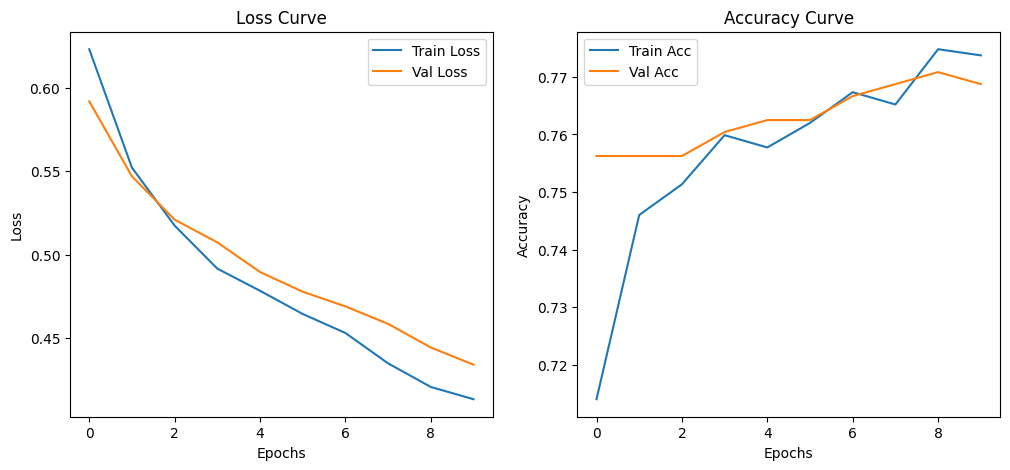

In [15]:
# --- Step 9: Plot Training Curves ---

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


In [16]:
# --- Step 10: Evaluate on Test Set ---

from sklearn.metrics import classification_report, confusion_matrix

model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy().round()
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.numpy())

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['real', 'fake']))


Testing: 100%|██████████| 15/15 [00:28<00:00,  1.87s/it]


Confusion Matrix:
[[339  20]
 [ 88  26]]

Classification Report:
              precision    recall  f1-score   support

        real       0.79      0.94      0.86       359
        fake       0.57      0.23      0.33       114

    accuracy                           0.77       473
   macro avg       0.68      0.59      0.59       473
weighted avg       0.74      0.77      0.73       473

